In [466]:
import torch

def h_poly_helper(tt):
  A = torch.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def H_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = t
  for i in range(1, 4):
    tt[i] = tt[i-1]*t*i/(i+1)
  return h_poly_helper(tt)

def interp_func(x, y):
  "Returns integral of interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  def f(xs):
    if len(y)==1: # in the case of 1 point, treat as constant function
      return y[0] + torch.zeros_like(xs)
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = h_poly((xs-x[I])/dx)
    return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
  return f

def interp(x, y, xs):
  return interp_func(x,y)(xs)

def integ_func(x, y):
  "Returns interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
    Y = torch.zeros_like(y)
    Y[1:] = (x[1:]-x[:-1])*(
        (y[:-1]+y[1:])/2 + (m[:-1] - m[1:])*(x[1:]-x[:-1])/12
        )
    Y = Y.cumsum(0)
  def f(xs):
    if len(y)==1:
      return y[0]*(xs - x[0])
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = H_poly((xs-x[I])/dx)
    return Y[I] + dx*(
        hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
        )
  return f

def integ(x, y, xs):
  return integ_func(x,y)(xs)

# Example
# See https://i.stack.imgur.com/zgA0s.png for resulting image

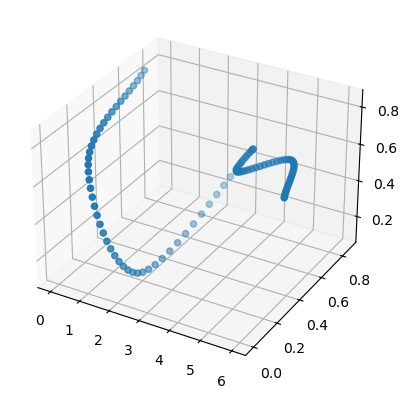

In [467]:
import matplotlib.pyplot as plt # for plotting
x = torch.linspace(0, 6, 7)
y = torch.rand(7)
z = torch.rand(7)
xs = torch.linspace(0, 6, 101)
ys = interp(x, y, xs)
zs = interp(x, z, xs)
xyzs = torch.stack((xs, ys, zs))
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(xs, ys, zs)

In [468]:
x_con = torch.linspace(0, 6, 7).requires_grad_(True)
y_con = torch.rand(7).requires_grad_(True)
z_con = torch.rand(7).requires_grad_(True)
xs_con = torch.linspace(0, 6, 101)

In [469]:
def loss_fn(target, predict):
    return torch.norm(target - predict)

In [470]:
optimizer = torch.optim.Adam([x_con, y_con, z_con], lr=0.01)

In [471]:
x_con.min().detach().numpy()

array(0., dtype=float32)

In [472]:
loss_array = []
pre_loss = 100
for i in range(350):
    xs_con = torch.linspace(float(x_con.min().detach().numpy()), float(x_con.max().detach().numpy()), 101)
    y_pre = interp(x_con, y_con, xs_con)
    z_pre = interp(x_con, z_con, xs_con)
    xyz_pre = torch.stack((xs_con, y_pre, z_pre))
    loss = loss_fn(xyzs, xyz_pre)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if abs(loss.detach() - pre_loss) < 0.001:
        loss_array.append(loss.detach())
        break
    pre_loss = loss.detach()
    loss_array.append(pre_loss)

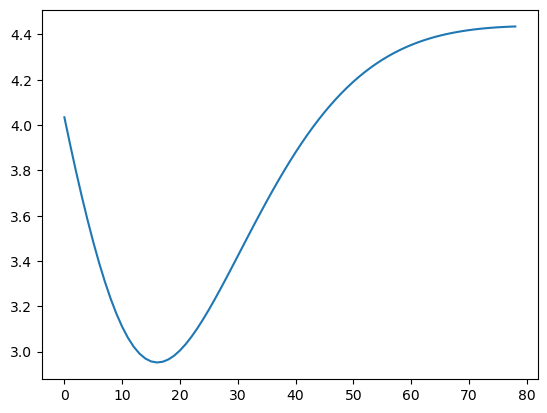

In [473]:
plt.plot(loss_array)

In [474]:
y_con

tensor([0.6916, 0.1109, 0.1274, 0.8443, 0.4729, 0.7215, 0.3456],
       requires_grad=True)

In [475]:
x_con

tensor([-0.4482,  0.4769,  1.4646,  2.5932,  3.7769,  4.5053,  5.5686],
       requires_grad=True)

In [476]:
z_con

tensor([0.7226, 0.7991, 0.1312, 0.4384, 0.5923, 0.5744, 0.6086],
       requires_grad=True)

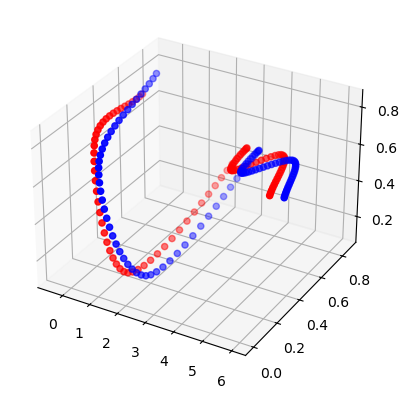

In [477]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(xs, ys, zs, c='b')
ax.scatter(xs_con, y_pre.detach(), z_pre.detach(), c='r')
